In [1]:
import arxiv
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from itertools import product
import re

### Using BeautifulSoup to scrape ar5iv website

ar5iv is an open-source project that converts PDF to HTML.

Since the Flesch Reading Ease Score is calculated using the total words, total sentences, and total syllables, I remove the equations from the text files.

In [2]:
AR5IV_ERROR_MSG = "Conversion to HTML had a Fatal error and exited abruptly. This document may be truncated or damaged."

def get_arxiv_text_from_id(id: str) -> tuple[str, int]:
    url = f"https://ar5iv.labs.arxiv.org/html/{id}"

    res = requests.get(url)
    if res.status_code == 200:
        soup = BeautifulSoup(res.text, "html.parser")
        eqns = soup.find_all('table', class_="ltx_equation")
        num_eqns = len(eqns)

        # Remove all eqns
        for eqn in eqns:
            eqn.decompose()

        # Remove inline equations
        annotations = soup.find_all('annotation')
        for ann in annotations:
            ann.decompose()
        
        #Remove math elements
        math_events = soup.find_all('math')
        for me in math_events:
            me.decompose()

        # text = soup.get_text(separator="\n") 
        text = soup.get_text() # Text without eqns

        if AR5IV_ERROR_MSG in text:
            raise Exception("ar5iv conversion error")

        return text, num_eqns
    
    else:
        raise Exception("HTML version not found")

### Downloading ArXiV papers

arXiv is a free distribution service and an open-access archive for scholarly articles in the fields of:
- physics
- mathematics
- computer science
- quantitative biology
- quantitative finance
- statistics
- electrical engineering and systems science
- economics

Materials uploaded to the arXiv site are not peer-reviewed by arXiv. 

https://arxiv.org/category_taxonomy

#### Downloading 1500 papers for each domain (excluding Physics)

In [4]:
domains = [
    "cs.*", "econ.*", "eess.*", "math.*", "q-bio.*", "q-fin.*", "stat.*", 
]

years = [2020 + i for i in range(5)]

client = arxiv.Client(
     page_size=2000,
     delay_seconds=10,
     num_retries=5
)

papers_per_domain = 1500
papers_per_year = papers_per_domain // 5

data = []

with tqdm(total=len(domains)*len(years), unit="pair") as pbar:
    for domain, year in product(domains, years):
        pbar.set_description(f"{domain}, {year}")
        year_filter = f"[{year}1010600 TO {year+1}01010600]"

        search = arxiv.Search(
            query=f"cat:{domain} AND submittedDate:{year_filter}",
            max_results=papers_per_year+300,
        )

        results = client.results(search)
        collected_data = []    
        i=0
        while len(collected_data) < papers_per_year:
            r = next(results)
            try:
                    text, num_eqns = get_arxiv_text_from_id(r.entry_id.split("/")[-1])
                    row_data = {
                        "domain": domain,
                        "category": r.categories,
                        "year": year,
                        "id": r.entry_id.split("/")[-1],
                        "title": r.title,
                        "author": r.authors,
                        "num_authors": len(r.authors),
                        "num_equations": num_eqns,
                        "journal_ref": r.journal_ref,
                        "abstract": r.summary,
                        "text": text,
                    }
                    collected_data.append(row_data)

            except Exception as e:
                i+=1
        print(f"{i} conversion errors")
        data.extend(collected_data)
        pbar.update(1)


df = pd.DataFrame(data)
df['domain'] = df['domain'].replace({
    "cs.*": 'Computer Science',
    "econ.*": 'Economics',
    "eess.*": 'Electrical Engineering and Systems Science',
    "math.*": 'Mathematics',
    "q-bio.*": 'Quantitative Biology',
    "q-fin.*": 'Quantitative Finance',
    "stat.*": 'Statistics'})

df.to_csv("nophy_arxiv_data.csv", index=False)

cs.*, 2021:   3%|▎         | 1/35 [02:19<1:19:03, 139.52s/pair]

16 conversion errors


cs.*, 2022:   6%|▌         | 2/35 [04:45<1:18:55, 143.49s/pair]

22 conversion errors


cs.*, 2023:   9%|▊         | 3/35 [07:13<1:17:30, 145.32s/pair]

27 conversion errors


cs.*, 2024:  11%|█▏        | 4/35 [09:39<1:15:13, 145.60s/pair]

13 conversion errors


econ.*, 2020:  14%|█▍        | 5/35 [12:33<1:17:57, 155.92s/pair]

18 conversion errors


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
econ.*, 2021:  17%|█▋        | 6/35 [15:46<1:21:24, 168.44s/pair]

15 conversion errors


econ.*, 2022:  20%|██        | 7/35 [19:02<1:22:52, 177.58s/pair]

20 conversion errors


econ.*, 2023:  23%|██▎       | 8/35 [23:11<1:30:09, 200.36s/pair]

22 conversion errors


econ.*, 2024:  26%|██▌       | 9/35 [27:00<1:30:41, 209.29s/pair]

13 conversion errors


eess.*, 2020:  29%|██▊       | 10/35 [30:14<1:25:13, 204.55s/pair]

17 conversion errors


eess.*, 2021:  31%|███▏      | 11/35 [32:05<1:10:23, 176.00s/pair]

11 conversion errors


eess.*, 2022:  34%|███▍      | 12/35 [34:04<1:00:46, 158.54s/pair]

16 conversion errors


eess.*, 2023:  37%|███▋      | 13/35 [36:03<53:44, 146.58s/pair]  

13 conversion errors


eess.*, 2024:  40%|████      | 14/35 [37:42<46:17, 132.26s/pair]

13 conversion errors


math.*, 2020:  43%|████▎     | 15/35 [39:16<40:10, 120.53s/pair]

9 conversion errors


math.*, 2021:  46%|████▌     | 16/35 [43:36<51:32, 162.78s/pair]

23 conversion errors


math.*, 2022:  49%|████▊     | 17/35 [48:12<59:00, 196.68s/pair]

22 conversion errors


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
math.*, 2023:  51%|█████▏    | 18/35 [52:59<1:03:26, 223.91s/pair]

28 conversion errors


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
math.*, 2024:  54%|█████▍    | 19/35 [59:15<1:11:51, 269.44s/pair]

13 conversion errors


q-bio.*, 2020:  57%|█████▋    | 20/35 [1:06:42<1:20:41, 322.74s/pair]

22 conversion errors


q-bio.*, 2021:  60%|██████    | 21/35 [1:08:02<58:21, 250.08s/pair]  

9 conversion errors


q-bio.*, 2022:  63%|██████▎   | 22/35 [1:09:43<44:29, 205.34s/pair]

4 conversion errors


q-bio.*, 2023:  66%|██████▌   | 23/35 [1:11:01<33:25, 167.13s/pair]

6 conversion errors


q-bio.*, 2024:  69%|██████▊   | 24/35 [1:12:22<25:51, 141.02s/pair]

2 conversion errors


q-fin.*, 2020:  71%|███████▏  | 25/35 [1:13:42<20:27, 122.75s/pair]

0 conversion errors


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
q-fin.*, 2021:  74%|███████▍  | 26/35 [1:15:57<18:58, 126.55s/pair]

16 conversion errors


q-fin.*, 2022:  77%|███████▋  | 27/35 [1:18:21<17:34, 131.79s/pair]

16 conversion errors


q-fin.*, 2023:  80%|████████  | 28/35 [1:26:45<28:23, 243.29s/pair]

19 conversion errors


q-fin.*, 2024:  83%|████████▎ | 29/35 [1:33:37<29:23, 293.99s/pair]

9 conversion errors


stat.*, 2020:  86%|████████▌ | 30/35 [1:38:14<24:05, 289.04s/pair] 

9 conversion errors


stat.*, 2021:  89%|████████▊ | 31/35 [1:41:33<17:27, 261.83s/pair]

19 conversion errors


stat.*, 2022:  91%|█████████▏| 32/35 [1:44:18<11:38, 232.93s/pair]

9 conversion errors


stat.*, 2023:  94%|█████████▍| 33/35 [1:47:19<07:14, 217.36s/pair]

13 conversion errors


stat.*, 2024:  97%|█████████▋| 34/35 [1:50:33<03:30, 210.34s/pair]

13 conversion errors


stat.*, 2024: 100%|██████████| 35/35 [1:53:27<00:00, 194.51s/pair]

7 conversion errors


#### Downloading 1500 papers from the Physics domain

In [6]:
physics_domains = [
"astro-ph.*", "cond-mat.*", "gr-qc", "hep-ex", "hep-lat", "hep-ph", "hep-th", 
 "math-ph", "nlin.*", "nucl-ex", "nucl-th", "physics.*", "quant-ph" 
]

years = [2020 + i for i in range(5)]

client = arxiv.Client(
     page_size=2000,
     delay_seconds=10,
     num_retries=5
)

papers_per_domain = 115
papers_per_year = papers_per_domain // 5

phy_data = []

with tqdm(total=len(physics_domains)*len(years), unit="pair") as pbar:
    for domain, year in product(physics_domains, years):
        pbar.set_description(f"{domain}, {year}")
        year_filter = f"[{year}1010600 TO {year+1}01010600]"

        search = arxiv.Search(
            query=f"cat:{domain} AND submittedDate:{year_filter}",
            max_results=papers_per_year+50,
        )

        results = client.results(search)
        collected_data = []    
        i=0
        while len(collected_data) < papers_per_year:
            r = next(results)
            try:
                    text, num_eqns = get_arxiv_text_from_id(r.entry_id.split("/")[-1])
                    row_data = {
                        "domain": domain,
                        "category": r.categories,
                        "year": year,
                        "id": r.entry_id.split("/")[-1],
                        "title": r.title,
                        "author": r.authors,
                        "num_authors": len(r.authors),
                        "num_equations": num_eqns,
                        "journal_ref": r.journal_ref,
                        "abstract": r.summary,
                        "text": text,
                    }
                    collected_data.append(row_data)

            except Exception as e:
                i+=1
        print(f"{i} conversion errors")
        phy_data.extend(collected_data)
        pbar.update(1)


phy_df = pd.DataFrame(phy_data)
phy_df["domain"] = "Physics"
phy_df.to_csv("phy_arxiv_data.csv", index=False)

astro-ph.*, 2021:   2%|▏         | 1/65 [00:44<47:29, 44.52s/pair]

0 conversion errors


astro-ph.*, 2022:   3%|▎         | 2/65 [01:27<45:56, 43.75s/pair]

2 conversion errors


astro-ph.*, 2023:   5%|▍         | 3/65 [02:01<40:23, 39.08s/pair]

1 conversion errors


astro-ph.*, 2024:   6%|▌         | 4/65 [02:34<37:18, 36.69s/pair]

0 conversion errors


cond-mat.*, 2020:   8%|▊         | 5/65 [02:53<30:19, 30.33s/pair]

2 conversion errors


cond-mat.*, 2021:   9%|▉         | 6/65 [03:55<40:35, 41.28s/pair]

0 conversion errors


cond-mat.*, 2022:  11%|█         | 7/65 [04:25<36:17, 37.55s/pair]

0 conversion errors


cond-mat.*, 2023:  12%|█▏        | 8/65 [05:07<37:00, 38.96s/pair]

2 conversion errors


cond-mat.*, 2024:  14%|█▍        | 9/65 [05:40<34:40, 37.16s/pair]

0 conversion errors


gr-qc, 2020:  15%|█▌        | 10/65 [05:58<28:34, 31.18s/pair]     

3 conversion errors


gr-qc, 2021:  17%|█▋        | 11/65 [06:33<29:02, 32.27s/pair]

0 conversion errors


gr-qc, 2022:  18%|█▊        | 12/65 [07:18<31:49, 36.03s/pair]

0 conversion errors


gr-qc, 2023:  20%|██        | 13/65 [07:48<29:39, 34.22s/pair]

2 conversion errors


gr-qc, 2024:  22%|██▏       | 14/65 [08:13<26:53, 31.64s/pair]

0 conversion errors


hep-ex, 2020:  23%|██▎       | 15/65 [08:42<25:43, 30.86s/pair]

0 conversion errors


hep-ex, 2021:  25%|██▍       | 16/65 [09:08<23:53, 29.26s/pair]

2 conversion errors


hep-ex, 2022:  26%|██▌       | 17/65 [09:28<21:11, 26.50s/pair]

0 conversion errors


hep-ex, 2023:  28%|██▊       | 18/65 [09:52<20:04, 25.62s/pair]

0 conversion errors


hep-ex, 2024:  29%|██▉       | 19/65 [10:23<21:01, 27.43s/pair]

0 conversion errors


hep-lat, 2020:  31%|███       | 20/65 [10:52<20:49, 27.78s/pair]

0 conversion errors


hep-lat, 2021:  32%|███▏      | 21/65 [11:08<17:48, 24.28s/pair]

1 conversion errors


hep-lat, 2022:  34%|███▍      | 22/65 [11:20<14:50, 20.72s/pair]

0 conversion errors


hep-lat, 2023:  35%|███▌      | 23/65 [11:36<13:24, 19.14s/pair]

0 conversion errors


hep-lat, 2024:  37%|███▋      | 24/65 [11:52<12:22, 18.11s/pair]

0 conversion errors


hep-ph, 2020:  38%|███▊      | 25/65 [12:09<11:56, 17.90s/pair] 

1 conversion errors


hep-ph, 2021:  40%|████      | 26/65 [12:36<13:23, 20.60s/pair]

1 conversion errors


hep-ph, 2022:  42%|████▏     | 27/65 [13:19<17:22, 27.43s/pair]

0 conversion errors


hep-ph, 2023:  43%|████▎     | 28/65 [14:09<20:58, 34.00s/pair]

2 conversion errors


hep-ph, 2024:  45%|████▍     | 29/65 [14:19<16:12, 27.01s/pair]

0 conversion errors


hep-th, 2020:  46%|████▌     | 30/65 [15:05<18:59, 32.57s/pair]

1 conversion errors


hep-th, 2021:  48%|████▊     | 31/65 [15:51<20:43, 36.56s/pair]

0 conversion errors


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
hep-th, 2022:  49%|████▉     | 32/65 [16:40<22:11, 40.36s/pair]

1 conversion errors


hep-th, 2023:  51%|█████     | 33/65 [17:17<20:56, 39.26s/pair]

3 conversion errors


hep-th, 2024:  52%|█████▏    | 34/65 [18:05<21:40, 41.95s/pair]

0 conversion errors


math-ph, 2020:  54%|█████▍    | 35/65 [18:43<20:27, 40.91s/pair]

0 conversion errors


math-ph, 2021:  55%|█████▌    | 36/65 [19:11<17:52, 36.98s/pair]

0 conversion errors


math-ph, 2022:  57%|█████▋    | 37/65 [19:45<16:50, 36.10s/pair]

2 conversion errors


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
math-ph, 2023:  58%|█████▊    | 38/65 [20:21<16:10, 35.93s/pair]

0 conversion errors


math-ph, 2024:  60%|██████    | 39/65 [20:59<15:49, 36.54s/pair]

2 conversion errors


nlin.*, 2020:  62%|██████▏   | 40/65 [21:28<14:22, 34.51s/pair] 

0 conversion errors


nlin.*, 2021:  63%|██████▎   | 41/65 [21:40<11:01, 27.56s/pair]

1 conversion errors


nlin.*, 2022:  65%|██████▍   | 42/65 [21:56<09:14, 24.13s/pair]

2 conversion errors


nlin.*, 2023:  66%|██████▌   | 43/65 [22:08<07:32, 20.59s/pair]

0 conversion errors


nlin.*, 2024:  68%|██████▊   | 44/65 [22:21<06:20, 18.13s/pair]

1 conversion errors


nucl-ex, 2020:  69%|██████▉   | 45/65 [22:36<05:44, 17.20s/pair]

0 conversion errors


nucl-ex, 2021:  71%|███████   | 46/65 [22:47<04:52, 15.40s/pair]

0 conversion errors


nucl-ex, 2022:  72%|███████▏  | 47/65 [23:03<04:39, 15.53s/pair]

1 conversion errors


nucl-ex, 2023:  74%|███████▍  | 48/65 [23:16<04:11, 14.81s/pair]

0 conversion errors


nucl-ex, 2024:  75%|███████▌  | 49/65 [23:33<04:07, 15.48s/pair]

1 conversion errors


nucl-th, 2020:  77%|███████▋  | 50/65 [23:48<03:51, 15.45s/pair]

1 conversion errors


nucl-th, 2021:  78%|███████▊  | 51/65 [24:05<03:39, 15.71s/pair]

0 conversion errors


nucl-th, 2022:  80%|████████  | 52/65 [24:45<05:00, 23.13s/pair]

0 conversion errors


nucl-th, 2023:  82%|████████▏ | 53/65 [25:05<04:27, 22.27s/pair]

2 conversion errors


nucl-th, 2024:  83%|████████▎ | 54/65 [25:28<04:06, 22.43s/pair]

0 conversion errors


physics.*, 2020:  85%|████████▍ | 55/65 [25:54<03:55, 23.55s/pair]

1 conversion errors


physics.*, 2021:  86%|████████▌ | 56/65 [26:48<04:53, 32.66s/pair]

0 conversion errors


physics.*, 2022:  88%|████████▊ | 57/65 [27:29<04:41, 35.21s/pair]

0 conversion errors


physics.*, 2023:  89%|████████▉ | 58/65 [28:14<04:25, 38.00s/pair]

2 conversion errors


physics.*, 2024:  91%|█████████ | 59/65 [28:51<03:45, 37.64s/pair]

0 conversion errors


quant-ph, 2020:  92%|█████████▏| 60/65 [29:23<02:59, 35.93s/pair] 

0 conversion errors


quant-ph, 2021:  94%|█████████▍| 61/65 [30:06<02:32, 38.06s/pair]

0 conversion errors


quant-ph, 2022:  95%|█████████▌| 62/65 [30:42<01:52, 37.56s/pair]

1 conversion errors


quant-ph, 2023:  97%|█████████▋| 63/65 [30:54<00:59, 29.99s/pair]

1 conversion errors


quant-ph, 2024:  98%|█████████▊| 64/65 [31:07<00:24, 24.89s/pair]

0 conversion errors


quant-ph, 2024: 100%|██████████| 65/65 [31:38<00:00, 29.21s/pair]

3 conversion errors


#### Combining the two datasets

In [ ]:
df1 = pd.read_csv("nophy_arxiv_data.csv")
df2 = pd.read_csv("phy_arxiv_data.csv")

combined_df = pd.concat([df1, df2], ignore_index=True)

In [112]:
combined_df.to_csv("combined_data.csv", index=False)

In [2]:
combined_df = pd.read_csv("combined_data.csv")

In [5]:
print(combined_df.shape)
print(combined_df.columns)

(11995, 11)
Index(['domain', 'category', 'year', 'id', 'title', 'author', 'num_authors',
       'num_equations', 'journal_ref', 'abstract', 'text'],
      dtype='object')


In [190]:
combined_df.head()

,domain,category,year,id,title,author,num_authors,num_equations,journal_ref,abstract,text
0,Computer Science,"['cs.DC', 'cs.MS', 'cs.PF', 'cs.SE']",2020,2011.08879v1,Ginkgo -- A Math Library designed for Platform...,"[arxiv.Result.Author('Terry Cojean'), arxiv.Re...",3,2,NaN,The first associations to software sustainabil...,\n\n\n[2011.08879] Ginkgo - A Math Library des...
1,Computer Science,"['cs.OS', 'cs.AR', 'cs.PF', 'D.4']",2020,2011.12092v1,Leveraging Architectural Support of Three Page...,"[arxiv.Result.Author('Venkat Sri Sai Ram'), ar...",3,0,NaN,Large pages are commonly deployed to reduce ad...,\n\n\n[2011.12092] Leveraging Architectural Su...
2,Computer Science,"['cs.AR', 'cs.AI', 'cs.ET', 'cs.PF']",2020,2010.12869v2,ExPAN(N)D: Exploring Posits for Efficient Arti...,"[arxiv.Result.Author('Suresh Nambi'), arxiv.Re...",6,1,NaN,"The recent advances in machine learning, in ge...",\n\n\n[2010.12869] ExPAN(N)D: Exploring Posits...
3,Computer Science,"['cs.ET', 'cs.AR', 'cs.DC', 'cs.NE']",2020,2011.09067v2,Distributed Injection-Locking in Analog Ising ...,[arxiv.Result.Author('M. Ali Vosoughi')],1,7,NaN,The oscillator-based Ising machine (OIM) is a ...,\n\n\n[2011.09067] Distributed Injection-Locki...
4,Computer Science,"['cs.AR', 'cs.DC', 'cs.ET', 'cs.LO']",2020,2011.08455v1,Revising the classic computing paradigm and it...,[arxiv.Result.Author('János Végh')],1,0,NaN,Today's computing is told to be based on the c...,\n\n\n[2011.08455] Revising the classic comput...


#### Using nltk to clean the text files (and extract metrics needed to calculate reading scores)

In [6]:
import re
import unicodedata
from functools import lru_cache
from pathlib import Path
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, cmudict
from nltk.probability import FreqDist

nltk.download('stopwords')
nltk.download('cmudict')
nltk.download('punkt')
nltk.download('punkt_tab')

_STOP_WORDS = set(stopwords.words("english"))
_CMU        = cmudict.dict()
_VOWELS     = re.compile(r"[aeiouy]+", re.I)

def text_clean(text: str) -> str:
    '''clean BeautifulSoup .get_text() output'''

    # remove citation markers like [1], [2], etc
    processed_text = re.sub(r'\[.*?\]\(.*?\)', '', text) 
    # remove URLs
    processed_text = re.sub(r'https?://\S+|www\.\S+', '', processed_text) 
    # make sure it doesn't remove list markers like [a]
    processed_text = re.sub(r'\[\s*\d+(?:\s*,\s*\d+)*\s*\]', '', processed_text) 
    processed_text = processed_text.lower()
    processed_text = processed_text.replace('\n', ' ')

    # find all "references" or "bibliography" and cut at the last one
    matches = list(re.finditer(r'\b(references|bibliography)\b', processed_text))
    if matches:
        processed_text = processed_text[:matches[-1].start()]

    # replace multiple spaces with a single space for cleaner output
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()
    
    return processed_text


def count_sentences(text):
    '''Get total sentence count across the document'''
    return len(sent_tokenize(text, language="english"))

def word_count(text):
    '''Get total word count across the document'''
    return sum(1 for tok in word_tokenize(text, language="english") if any(c.isalnum() for c in tok))

@lru_cache(maxsize=50_000) 
def syllables_in_word(word: str) -> int:
    word = word.lower()
    if word in _CMU:
        return min(sum(p[-1].isdigit() for p in pron) for pron in _CMU[word])
    return len(_VOWELS.findall(word))  

def total_syllables(text: str) -> int:
    """Total syllable count across the whole (cleaned) document"""
    return sum(
        syllables_in_word(tok)
        for tok in word_tokenize(text, language="english")
        if any(c.isalpha() for c in tok)
    )


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandiniprasad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/nandiniprasad/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nandiniprasad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nandiniprasad/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Testing out if data was cleaned

In [9]:
test_text = combined_df.iloc[0]["text"]
test_text

'\n\n\n[2011.08879] Ginkgo - A Math Library designed for Platform Portability\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGinkgo - A Math Library designed for Platform Portability\n\n\n Terry Cojean⋆, Yu-Hsiang Mike Tsai⋆, and Hartwig\nAnzt⋆†\n\n⋆Steinbuch Centre for Computing, Karlsruhe Institute of\nTechnology, Germany\n†Innovative Computing Lab, University of\nTennessee, USA\n\n\n\nAbstract\nThe first associations to software sustainability might be the existence of a continuous integration (CI) framework; the existence of a testing framework composed of unit tests, integration tests, and end-to-end tests; and also the existence of software documentation. However, when asking what is a common deathblow for a scientific software product, it is often the lack of platform and performance portability. Against this background, we designed the Ginkgo library with the primary focus on platform portability and the ability to not only port to new hardware architectures, but also achieve good pe

In [10]:
text_clean(test_text)

'[2011.08879] ginkgo - a math library designed for platform portability ginkgo - a math library designed for platform portability terry cojean⋆, yu-hsiang mike tsai⋆, and hartwig anzt⋆† ⋆steinbuch centre for computing, karlsruhe institute of technology, germany †innovative computing lab, university of tennessee, usa abstract the first associations to software sustainability might be the existence of a continuous integration (ci) framework; the existence of a testing framework composed of unit tests, integration tests, and end-to-end tests; and also the existence of software documentation. however, when asking what is a common deathblow for a scientific software product, it is often the lack of platform and performance portability. against this background, we designed the ginkgo library with the primary focus on platform portability and the ability to not only port to new hardware architectures, but also achieve good performance. in this paper we present the ginkgo library design, radic

Clean the text and extract word count, sentence count, syllable count for calculting FRES

In [11]:
# replacing all the text in the combined_df with clean text
combined_df["text"] = combined_df["text"].apply(lambda x: text_clean(x))

# get word count, sentence count, syllable count from cleaned text
combined_df["word_count"] = combined_df["text"].apply(lambda x: word_count(x))
combined_df["sentence_count"] = combined_df["text"].apply(lambda x: count_sentences(x))
combined_df["syllable_count"] = combined_df["text"].apply(lambda x: total_syllables(x))

### Calculating Flesch Reading-Ease

In the Flesch reading-ease test, higher scores indicate material that is easier to read, while lower numbers mark passages that are more difficult to read. The formula for the Flesch reading-ease score (FRES) test is:


$$\text{FRES} = 206.835 - 1.015 \left( \frac{\text{total words}}{\text{total sentences}} \right) - 84.6 \left( \frac{\text{total syllables}}{\text{total words}} \right)$$


In [12]:
def get_FRES(row):
    score = 206.835 - 1.015*(row['word_count']/row['sentence_count']) - 84.6*(row['syllable_count']/row['word_count'])
    return score

combined_df["FRES"] = combined_df[["word_count", "sentence_count", "syllable_count"]].apply(lambda x: get_FRES(x), axis=1)

In [13]:
print(combined_df.shape)
print(combined_df.columns)

(11995, 15)
Index(['domain', 'category', 'year', 'id', 'title', 'author', 'num_authors',
       'num_equations', 'journal_ref', 'abstract', 'text', 'word_count',
       'sentence_count', 'syllable_count', 'FRES'],
      dtype='object')


In [14]:
combined_df[["num_authors", "num_equations", "word_count", "sentence_count", "syllable_count", "FRES"]].describe()

,num_authors,num_equations,word_count,sentence_count,syllable_count,FRES
count,11995.000000,11995.00000,11995.000000,11995.000000,11995.000000,11995.000000
mean,6.249354,24.44035,5776.060192,275.418758,9885.246603,33.786432
std,43.059850,49.32270,5162.731518,271.189822,8795.447340,17.887194
min,1.000000,0.00000,13.000000,1.000000,30.000000,-144.750029
25%,2.000000,0.00000,2465.000000,115.500000,4230.500000,26.330275
50%,3.000000,6.00000,5147.000000,237.000000,8853.000000,36.483010
75%,4.000000,27.00000,7999.500000,375.000000,13766.000000,44.801282
max,1149.000000,1759.00000,152503.000000,9755.000000,269186.000000,190.468115


### Removing outliers that arose from my data extraction and text cleaning method

Out of 11995 papers, 6 papers got a FRES score greater than the theoretical limit of 121.22. Upon investigation found that they have fewer total syllables than the total word count which does not make sense.

In [15]:
combined_df[combined_df["FRES"] > 121.22]

,domain,category,year,id,title,author,num_authors,num_equations,journal_ref,abstract,text,word_count,sentence_count,syllable_count,FRES
4732,Mathematics,"['math.CV', 'math.AT', 'math.GT']",2020,2010.10265v1,The Profiles of Riemann Surfaces,"[arxiv.Result.Author('Semen Bronza'), arxiv.Re...",2,1,NaN,"Riemann surfaces which are set by algebraic, a...","[2010.10265] рис. 1. бронза с. д., таирова в. ...",1407,105,46,190.468115
4802,Mathematics,"['math.RA', 'math.AG', 'math.CT', 'math.KT', '...",2021,2111.09810v4,(Co)module algebras and their generalizations,[arxiv.Result.Author('Alexey Gordienko')],1,54,NaN,This manuscript is an extended version of the ...,[2111.09810] оглавление оглавление 1 основные ...,6080,419,530,184.731928
5515,Mathematics,['math.HO'],2023,2310.16443v1,"Platonism, De Re, and (Philosophy of) Mathemat...",[arxiv.Result.Author('Marco Panza')],1,8,B. Sriraman. Handbook of the History and Philo...,The chapter advances a reformulation of the cl...,"[2310.16443] platonism, de re, and (philosophy...",15023,572,5034,151.828762
5878,Mathematics,"['math.GT', 'cs.CG', 'math.CO', 'math.HO', '57...",2024,2410.09860v1,Invariants of almost embeddings of graphs in t...,"[arxiv.Result.Author('E. Alkin'), arxiv.Result...",4,67,NaN,In this survey we motivate studies of the inva...,[2410.09860] инварианты почти вложений графов ...,6760,610,646,187.502247
5985,Mathematics,"['math.GR', 'math.GN', '22M15, 54A10, 54D10, 5...",2024,2412.20886v1,On compact topologies on the semigroup of fini...,"[arxiv.Result.Author('Oleg Gutik'), arxiv.Resu...",2,12,NaN,We study topologization of the semigroup $\mat...,[2412.20886] про компактнi топологiï на напiвг...,2962,260,1901,140.975859
11496,Physics,"['nlin.AO', 'nlin.CD']",2023,2312.06666v1,Synchronization and movement control of an ens...,"[arxiv.Result.Author('E. M. Varvarin'), arxiv....",2,7,NaN,This article suggests ways to implement sequen...,[2312.06666] синхронизация и управление движен...,1621,139,452,171.408319


#### FRES Outlier Detection and Removal

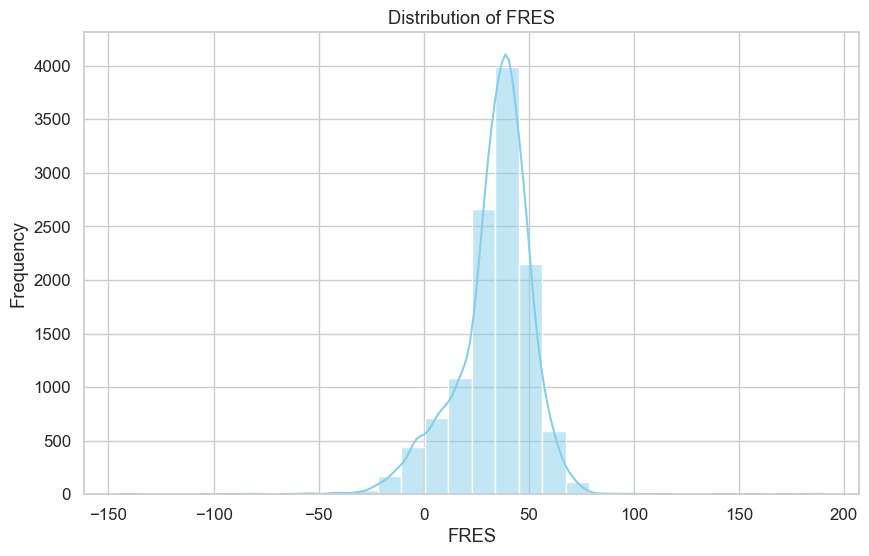

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

plt.figure(figsize=(10, 6))
sns.histplot(combined_df["FRES"], kde=True, bins=30, color="skyblue")
plt.title("Distribution of FRES")
plt.xlabel("FRES")
plt.ylabel("Frequency")
plt.show()

(array([  0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   2.,   3.,
          1.,   0.,   4.,   5.,   2.,   2.,   5.,   6.,  15.,  26.,  25.,
         43.,  67.,  62.,  93., 141., 152.]),
 array([-150., -147., -144., -141., -138., -135., -132., -129., -126.,
        -123., -120., -117., -114., -111., -108., -105., -102.,  -99.,
         -96.,  -93.,  -90.,  -87.,  -84.,  -81.,  -78.,  -75.,  -72.,
         -69.,  -66.,  -63.,  -60.,  -57.,  -54.,  -51.,  -48.,  -45.,
         -42.,  -39.,  -36.,  -33.,  -30.,  -27.,  -24.,  -21.,  -18.,
         -15.,  -12.,   -9.,   -6.,   -3.,    0.]),
 <BarContainer object of 50 artists>)

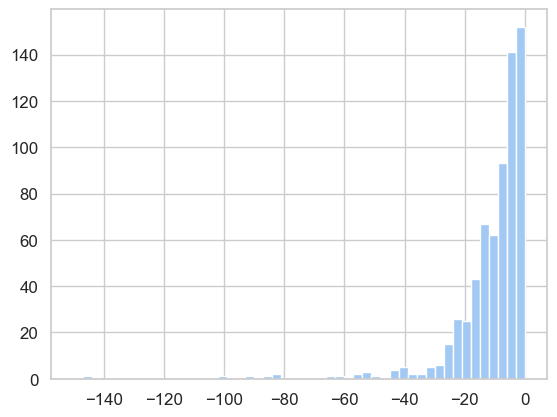

In [19]:
plt.hist(combined_df["FRES"], bins=50, range=(-150, 0))

(0.0, 100.0)

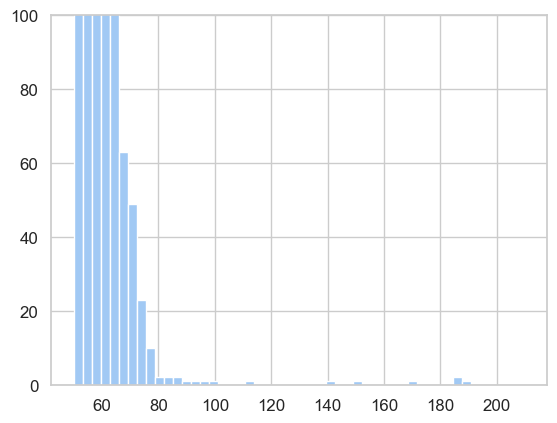

In [20]:
plt.hist(combined_df["FRES"], bins=50, range=(50, 210))
plt.ylim(0,100)

In [37]:
# Remove FRES outliers
clean_df = combined_df[combined_df["FRES"] > -50]
clean_df = clean_df[clean_df["FRES"] < 80]
clean_df.shape

(11967, 15)

#### Sentence Count Outlier Detection and Removal

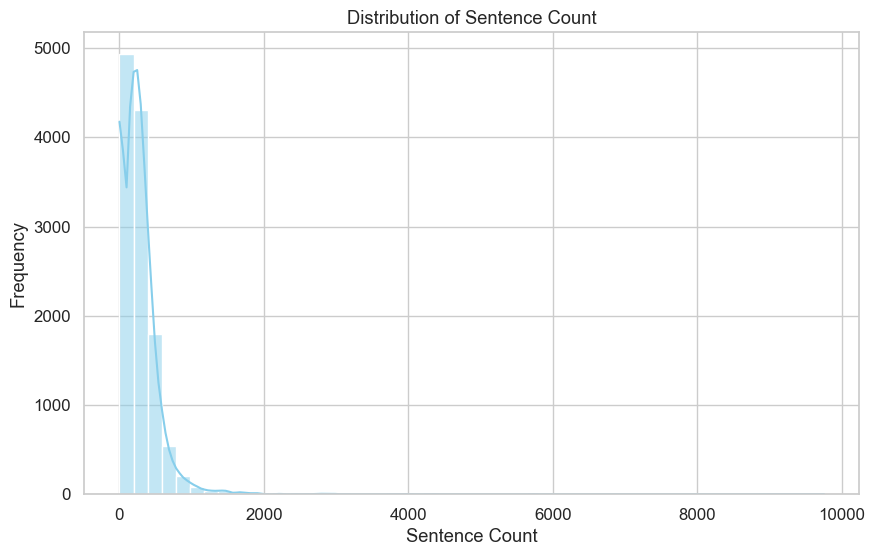

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(clean_df["sentence_count"], kde=True, bins=50, color="skyblue")
plt.title("Distribution of Sentence Count")
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.show()

In [24]:
'''total sentences count <20 appear to have improper conversion errors --
   either due to error in the pdf to html conversion before, and/or
   there is chance that our cleaning pipeline is incompatible with the 
   format used by some papers'''
print(clean_df[clean_df["sentence_count"] < 10]["text"].iloc[0])

[2012.05419v2] a custom 7nm cmos standard cell library for implementing tnn-based neuromorphic processors skip to main content we gratefully acknowledge support from the simons foundation, member institutions, and all contributors. donate > cs > arxiv:2012.05419v2 help | advanced search all fields title author abstract comments journal reference acm classification msc classification report number arxiv identifier doi orcid arxiv author id help pages full text search open search go open navigation menu quick links login help pages about computer science > hardware architecture arxiv:2012.05419v2 (cs) this paper has been withdrawn by harideep nair [submitted on 10 dec 2020 (v1), last revised 4 jun 2021 (this version, v2)] title:a custom 7nm cmos standard cell library for implementing tnn-based neuromorphic processors authors:harideep nair, prabhu vellaisamy, santha bhasuthkar, john paul shen view a pdf of the paper titled a custom 7nm cmos standard cell library for implementing tnn-based

In [29]:
# Example of improper pdf to html conversion (before web scraping)
df1[df1["id"]=="2012.05419v2"]["text"].iloc[0]

"\n\n [2012.05419v2] A Custom 7nm CMOS Standard Cell Library for Implementing TNN-based Neuromorphic Processors\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  \n\n\n\n\n\n\n\n\nSkip to main content\n\n\n\n\n\n\nWe gratefully acknowledge support from the Simons Foundation, member institutions, and all contributors.\nDonate\n\n\n\n\n\n > cs > arXiv:2012.05419v2\n  \n\n\n\n\n\nHelp | Advanced Search\n\n\n\n\nAll fields\nTitle\nAuthor\nAbstract\nComments\nJournal reference\nACM classification\nMSC classification\nReport number\narXiv identifier\nDOI\nORCID\narXiv author ID\nHelp pages\nFull text\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nopen search\n\n\n\n\n\n\nGO\n\n\n\nopen navigation menu\n\n\nquick links\n\nLogin\nHelp Pages\nAbout\n\n\n\n\n\n\n\n\n\n\n\n\nComputer Science > Hardware Architecture\n\n\narXiv:2012.05419v2 (cs)\n    \n\n\n\nThis paper has been withdrawn by Harideep Nair\n\n  [Submitted on 10 Dec 2020 (v1), last revised 4 Jun 2021 (this version, v2)]\nTi

(array([  33.,  497., 1033.,  422.,   83.,   15.,    9.,    8.,   14.,
          21.,   19.,   27.,   20.,   22.,   32.,   35.,   37.,   43.,
          39.,   49.,   44.,   45.,   52.,   48.,   51.,   73.,   74.,
          75.,   64.,   81.,   99.,  106.,   89.,  106.,  106.,   87.,
         108.,  112.,  100.,  106.,  109.,   94.,  107.,   87.,   87.,
          77.,   92.,   74.,   96.,  121.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <BarContainer object of 50 artists>)

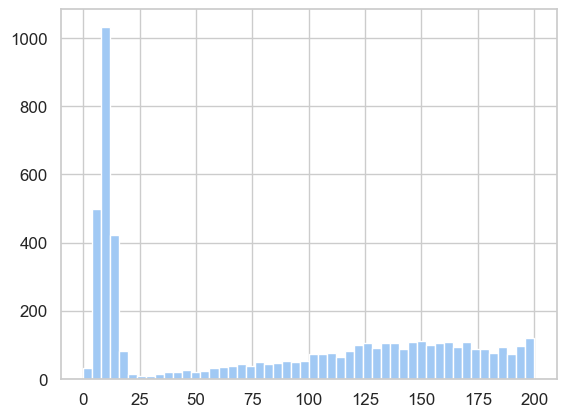

In [30]:
plt.hist(clean_df["sentence_count"], bins=50, range=(0,200))

In [ ]:
# Remove total sentence count outliers
clean_df = clean_df[clean_df["sentence_count"] > 50]
clean_df.shape

(9771, 15)

#### Syllable Count Outlier Detection and Removal

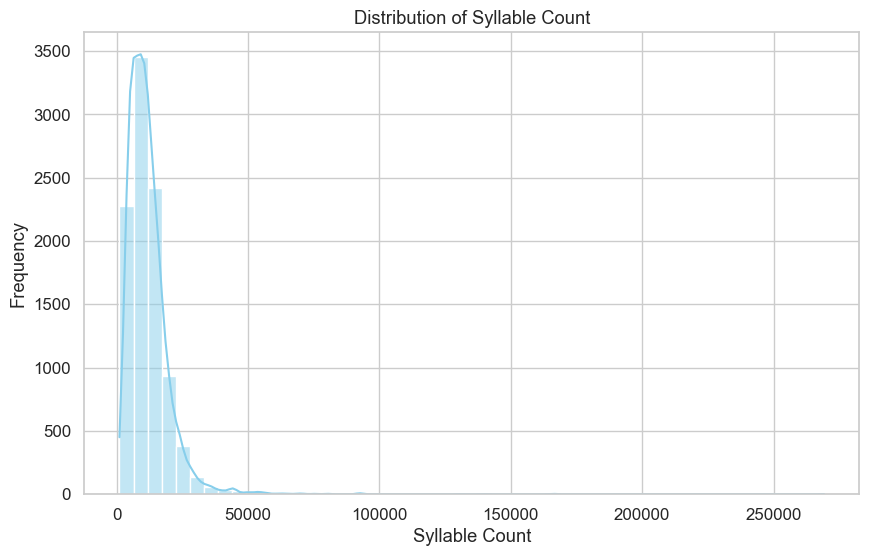

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(clean_df["syllable_count"], kde=True, bins=50, color="skyblue")
plt.title("Distribution of Syllable Count")
plt.xlabel("Syllable Count")
plt.ylabel("Frequency")
plt.show()

(array([  0.,   0.,   0.,   0.,   2.,   7.,  10.,  20.,  24.,  50.,  63.,
         68.,  68.,  79.,  88., 108., 120., 125., 152., 146., 150., 170.,
        188., 187., 147., 174., 134., 147., 160., 144., 144., 149., 185.,
        130., 156., 152., 148., 167., 171., 161., 185., 133., 133., 162.,
        143., 175., 162., 142., 153., 152.]),
 array([    0.,   240.,   480.,   720.,   960.,  1200.,  1440.,  1680.,
         1920.,  2160.,  2400.,  2640.,  2880.,  3120.,  3360.,  3600.,
         3840.,  4080.,  4320.,  4560.,  4800.,  5040.,  5280.,  5520.,
         5760.,  6000.,  6240.,  6480.,  6720.,  6960.,  7200.,  7440.,
         7680.,  7920.,  8160.,  8400.,  8640.,  8880.,  9120.,  9360.,
         9600.,  9840., 10080., 10320., 10560., 10800., 11040., 11280.,
        11520., 11760., 12000.]),
 <BarContainer object of 50 artists>)

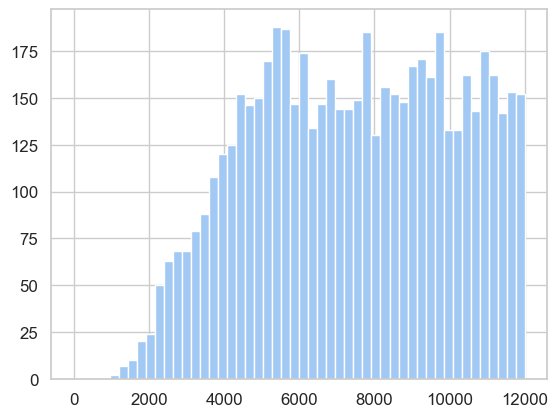

In [45]:
plt.hist(clean_df["syllable_count"], bins=50, range=(0,12000))

In [46]:
# Remove total syllable count outliers
clean_df = clean_df[clean_df["syllable_count"] > 1500]
clean_df.shape

(9759, 15)

#### Word Count Outlier Detection and Removal

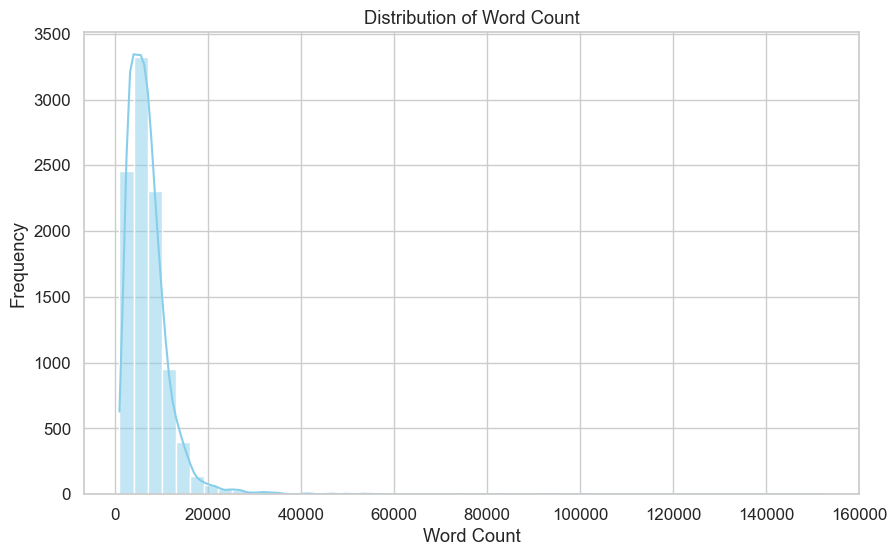

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(clean_df["word_count"], kde=True, bins=50, color="skyblue")
plt.title("Distribution of Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  11.,  20.,  27.,
         41.,  52.,  57.,  51.,  63.,  70.,  73.,  83., 100., 104., 119.,
        118., 127., 121., 150., 147., 154., 148., 122., 135., 128., 113.,
        134., 128., 121., 127., 122., 130., 142., 117., 126., 129., 116.,
        149., 142., 121., 142., 156., 119.]),
 array([    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1400.,
         1600.,  1800.,  2000.,  2200.,  2400.,  2600.,  2800.,  3000.,
         3200.,  3400.,  3600.,  3800.,  4000.,  4200.,  4400.,  4600.,
         4800.,  5000.,  5200.,  5400.,  5600.,  5800.,  6000.,  6200.,
         6400.,  6600.,  6800.,  7000.,  7200.,  7400.,  7600.,  7800.,
         8000.,  8200.,  8400.,  8600.,  8800.,  9000.,  9200.,  9400.,
         9600.,  9800., 10000.]),
 <BarContainer object of 50 artists>)

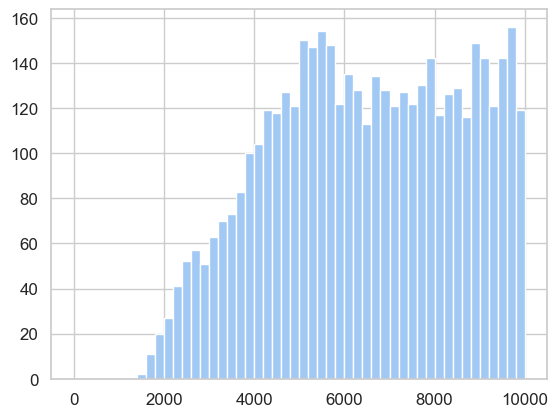

In [51]:
plt.hist(clean_df["syllable_count"], bins=50, range=(0,10000))

In [52]:
# Remove total word count outliers
clean_df = clean_df[clean_df["word_count"] > 2000]
clean_df.shape

(9349, 15)

### Save clean data

In [53]:
clean_df.to_csv("clean_data.csv", index=False)

## EDA

In [65]:
df = pd.read_csv("clean_data.csv")

In [71]:
df['domain'] = df['domain'].replace({
    "Computer Science": 'cs',
    "Economics": 'econ',
    "Electrical Engineering and Systems Science": 'eess',
    "Mathematics": 'math',
    "Quantitative Biology": 'q-bio',
    "Quantitative Finance": 'q-fin',
    "Statistics": 'stat',
    "Physics": 'phys'
    })

In [66]:
df[["num_authors", "num_equations", "word_count", "sentence_count", "syllable_count", "FRES"]].describe()

,num_authors,num_equations,word_count,sentence_count,syllable_count,FRES
count,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000
mean,6.927907,30.650658,7222.263985,346.374906,12362.351268,39.417616
std,48.653462,54.007089,4946.751828,266.544773,8436.537841,11.083328
min,1.000000,0.000000,2001.000000,55.000000,2710.000000,-27.911733
25%,2.000000,2.000000,4206.000000,198.000000,7251.000000,32.137930
50%,3.000000,11.000000,6327.000000,291.000000,10859.000000,39.256025
75%,4.000000,36.000000,8841.000000,420.000000,15219.000000,46.367746
max,1149.000000,1759.000000,152503.000000,9755.000000,269186.000000,79.173660


In [89]:
domains = list(pd.Series(df["domain"].value_counts().index).values)

for domain in domains:
    print(domain)
    print(df[df["domain"] == domain].describe())

stat
              year  num_authors  num_equations     word_count  sentence_count  \
count  1324.000000  1324.000000    1324.000000    1324.000000     1324.000000   
mean   2022.010574     3.266616      28.617069    7547.960725      331.574018   
std       1.411499     2.624797      39.535080    5610.664626      320.213756   
min    2020.000000     1.000000       0.000000    2004.000000       79.000000   
25%    2021.000000     2.000000       6.000000    5379.000000      231.000000   
50%    2022.000000     3.000000      17.000000    6854.500000      293.000000   
75%    2023.000000     4.000000      34.250000    8739.750000      383.000000   
max    2024.000000    80.000000     425.000000  152503.000000     9755.000000   

       syllable_count         FRES  
count     1324.000000  1324.000000  
mean     13011.916918    36.594731  
std       9773.731007     9.625479  
min       3363.000000     4.571772  
25%       9305.750000    30.155034  
50%      11884.000000    36.222998  
75%   

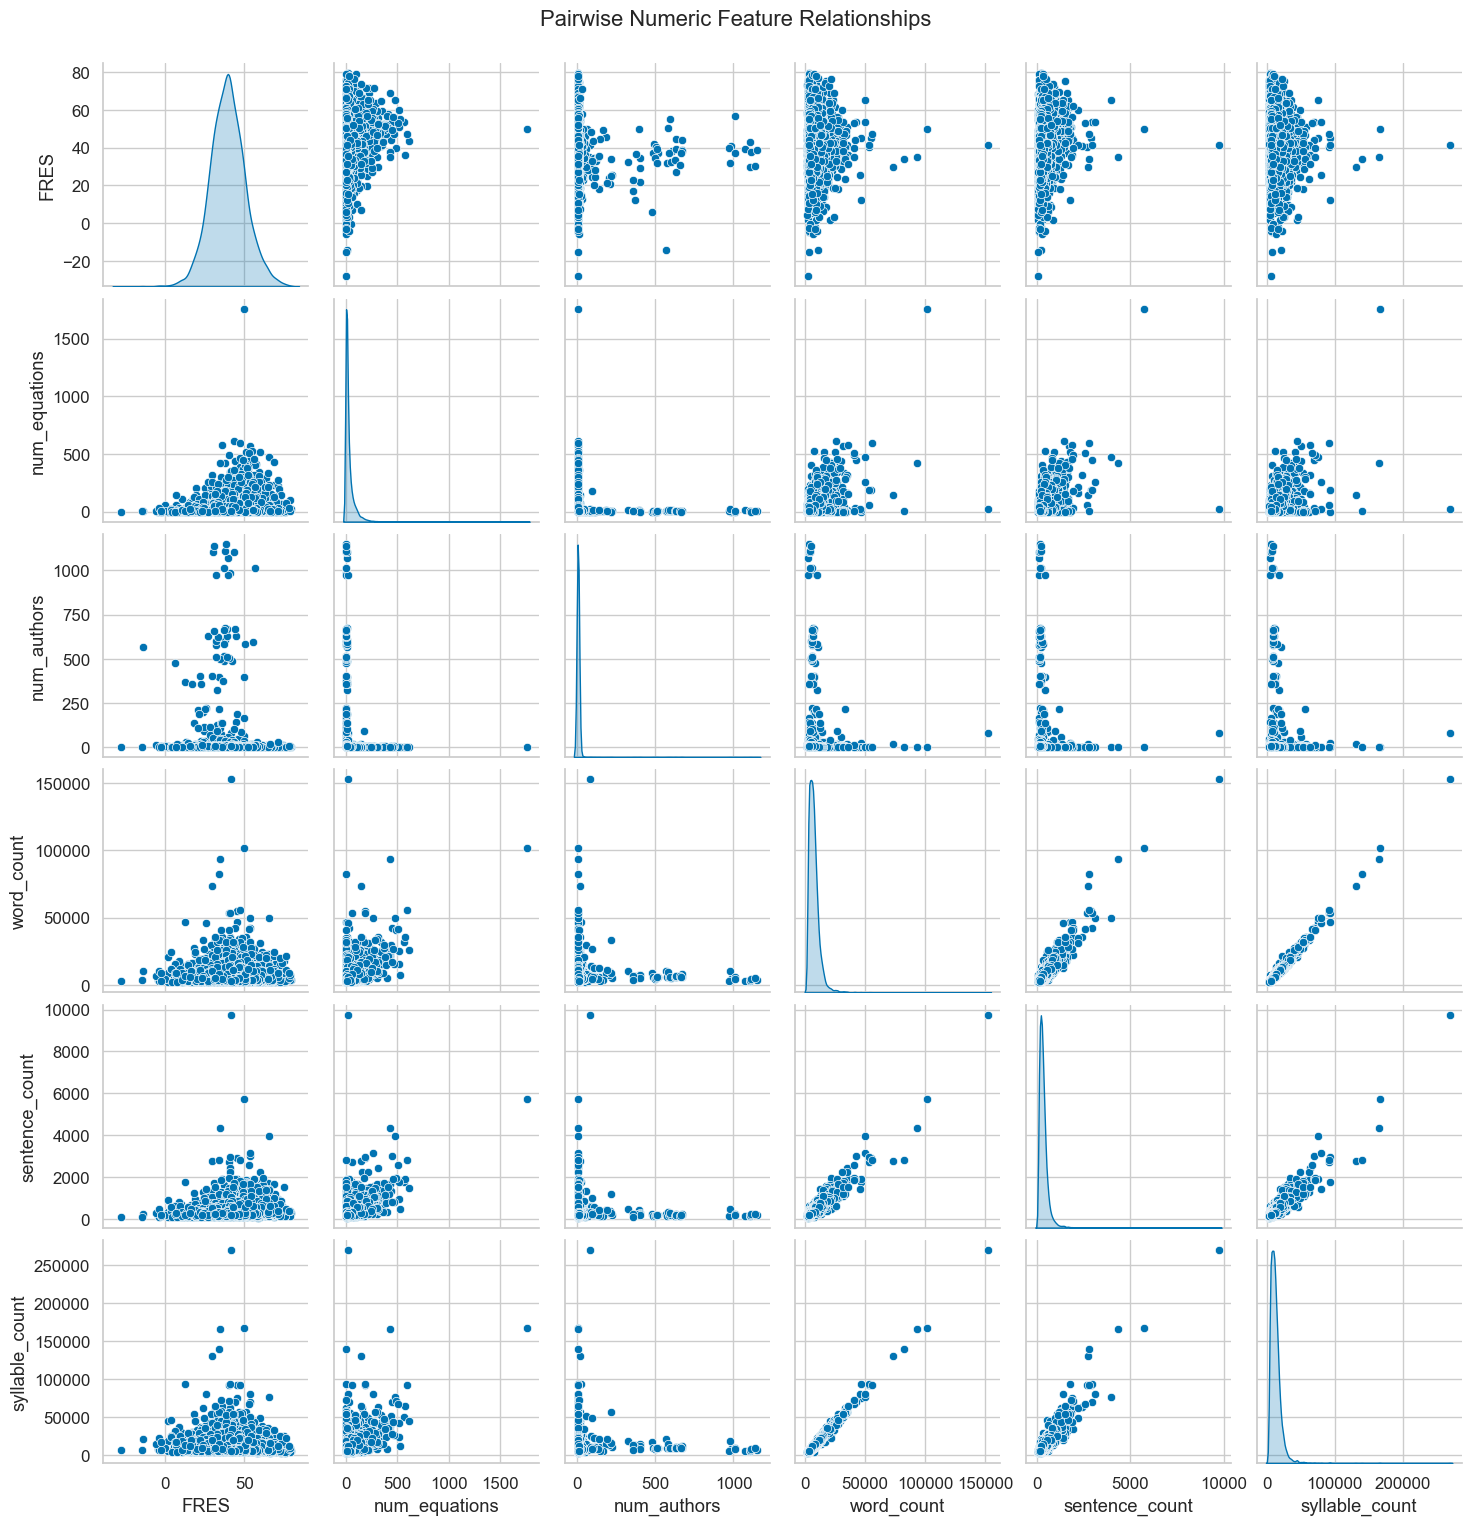

In [86]:
# Pairplot for numeric relationships
numerics = ["FRES", "num_equations", "num_authors", "word_count", "sentence_count", "syllable_count"]
sns.pairplot(df[numerics], diag_kind="kde")
plt.suptitle("Pairwise Numeric Feature Relationships", y=1.02)
plt.show()

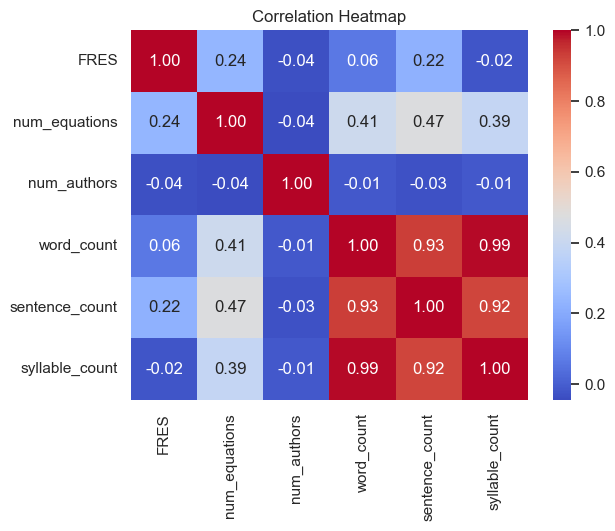

In [98]:
# Correlation heatmap
numerics = ["FRES", "num_equations", "num_authors", "word_count", "sentence_count", "syllable_count"]
sns.heatmap(clean_df[numerics].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

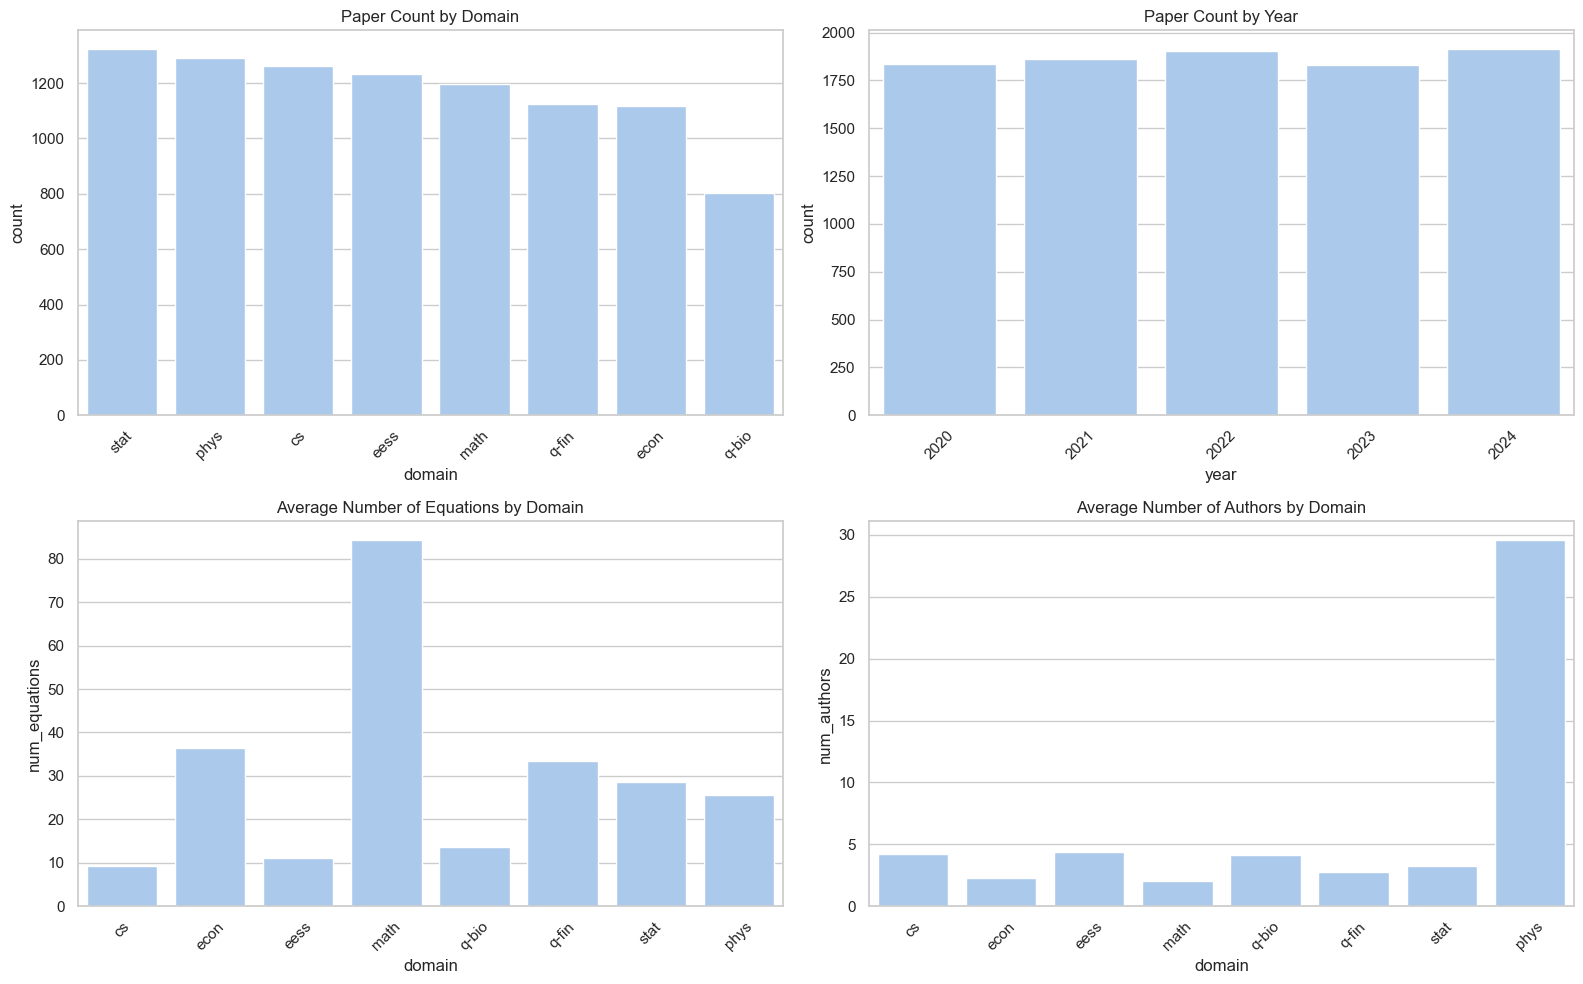

In [92]:
sns.set(style="whitegrid", palette="pastel")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# 1. Paper count by domain
sns.countplot(data=df, x="domain", order=df["domain"].value_counts().index, ax=axs[0, 0])
axs[0, 0].set_title("Paper Count by Domain")
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Paper count by year
sns.countplot(data=df, x="year", order=sorted(df["year"].unique()), ax=axs[0, 1])
axs[0, 1].set_title("Paper Count by Year")
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Average number of equations by domain
sns.barplot(data=df, x="domain", y="num_equations", estimator="mean", errorbar=None, ax=axs[1, 0])
axs[1, 0].set_title("Average Number of Equations by Domain")
axs[1, 0].tick_params(axis='x', rotation=45)

# 4. Average number of authors by domain
sns.barplot(data=df, x="domain", y="num_authors", estimator="mean", errorbar=None, ax=axs[1, 1])
axs[1, 1].set_title("Average Number of Authors by Domain")
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [75]:
df["domain"].value_counts()

domain
stat     1324
phys     1292
cs       1260
eess     1234
math     1196
q-fin    1123
econ     1116
q-bio     804
Name: count, dtype: int64

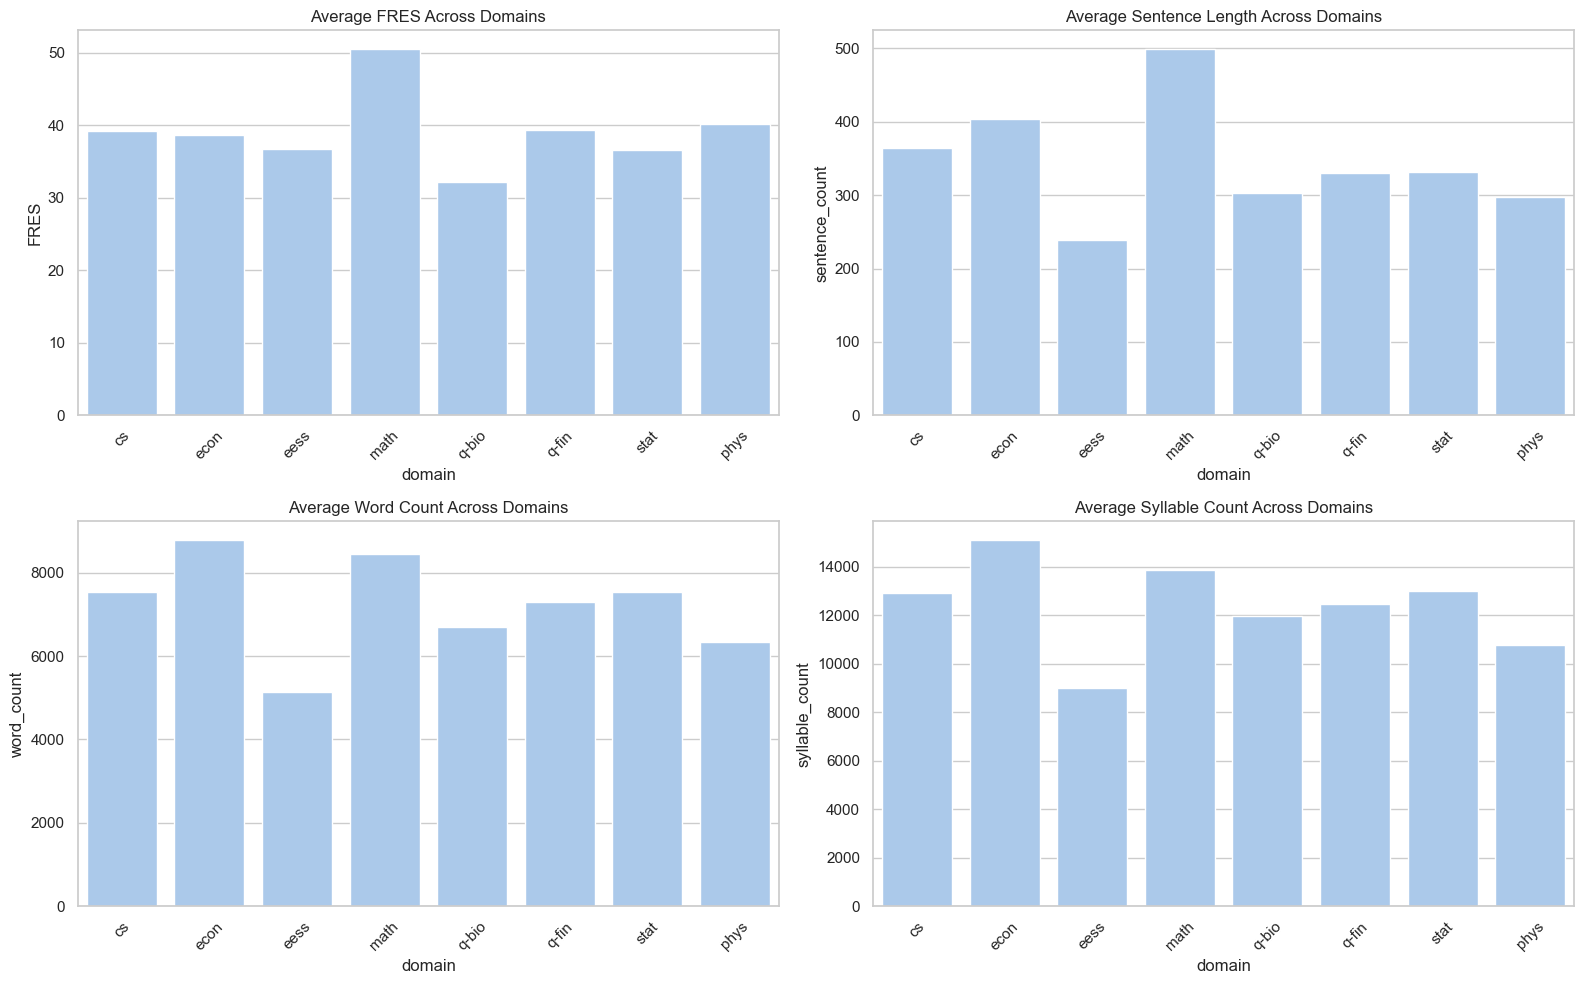

In [95]:
sns.set(style="whitegrid", palette="pastel")
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Average FRES
sns.barplot(data=df, x="domain", y="FRES", estimator="mean", errorbar=None, ax=axs[0, 0])
axs[0, 0].set_title("Average FRES Across Domains")
axs[0, 0].tick_params(axis='x', rotation=45)

# Average Sentence Length
sns.barplot(data=df, x="domain", y="sentence_count", estimator="mean", errorbar=None, ax=axs[0, 1])
axs[0, 1].set_title("Average Sentence Length Across Domains")
axs[0, 1].tick_params(axis='x', rotation=45)

# Average Word Count Across Domains
sns.barplot(data=df, x="domain", y="word_count", estimator="mean", errorbar=None, ax=axs[1, 0])
axs[1, 0].set_title("Average Word Count Across Domains")
axs[1, 0].tick_params(axis='x', rotation=45)

# Average Syllable Count Across Domains
sns.barplot(data=df, x="domain", y="syllable_count", estimator="mean", errorbar=None, ax=axs[1, 1])
axs[1, 1].set_title("Average Syllable Count Across Domains")
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

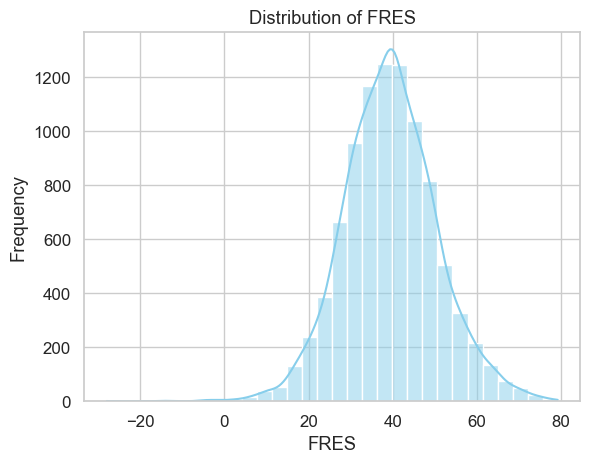

In [68]:
# FRES distribution
sns.histplot(df["FRES"], kde=True, bins=30, color="skyblue")
plt.title("Distribution of FRES")
plt.xlabel("FRES")
plt.ylabel("Frequency")
plt.show()

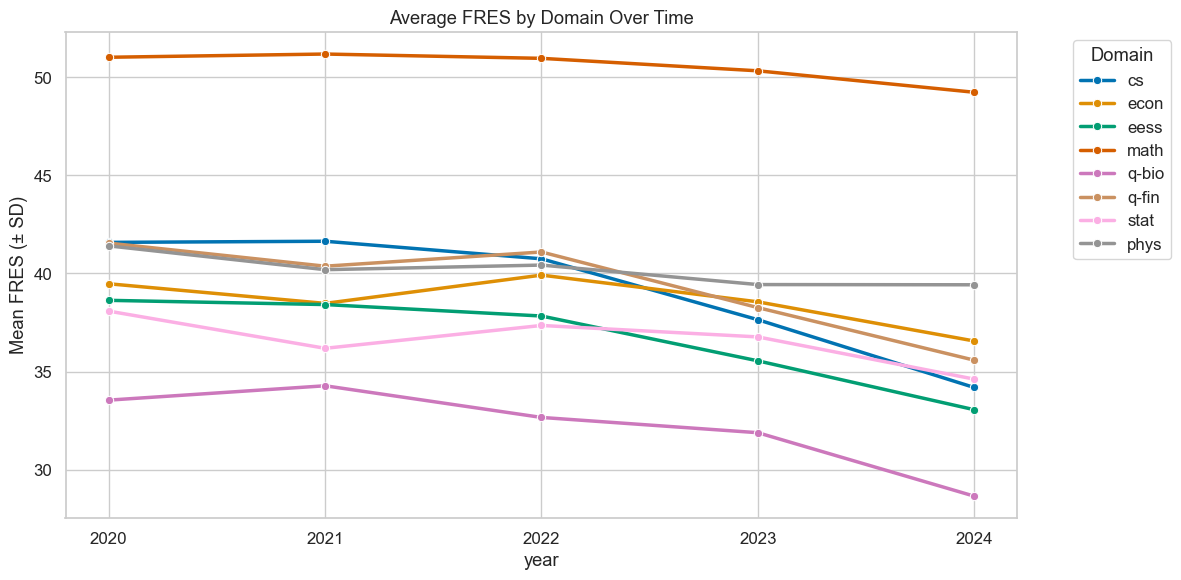

In [85]:
# FRES over time per domain
plt.figure(figsize=(12, 6))
sns.set_palette("colorblind")
sns.lineplot(data=df, x="year", y="FRES", hue="domain", marker="o", estimator="mean", errorbar=None, linewidth=2.5)
plt.title("Average FRES by Domain Over Time")
plt.ylabel("Mean FRES (± SD)")
plt.xticks(ticks=df["year"].unique(), labels=df["year"].unique())
plt.legend(title="Domain", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()